In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate, ZeroPadding2D

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [2]:
currentPath = os.getcwd()
print(currentPath)

/home/ec2-user/SageMaker


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


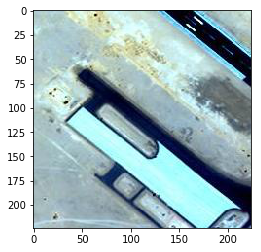

In [4]:
trainDB = currentPath + os.sep + "dataset" +  os.sep + "train20"
valDB = currentPath + os.sep + "dataset" +  os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
DenseNetWeightsPretrained = currentPath + os.sep + "DenseNet-BC-161-48-no-top.h5"


model_name = "DenseNet-161"
classList = os.listdir(trainDB)
classList.sort()

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_18_0_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00032
batch_size = 20
num_epochs = 700
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 925 images belonging to 62 classes.
Found 309 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
convcnt = 1
def bn_relu_conv(x, filters, kernel_size):
    global convcnt
    convcnt = convcnt + 1
    x = BatchNormalization(name= "batch_normalization_"+str(convcnt))(x)
    x = ReLU()(x) 
    x = Conv2D(filters, kernel_size, padding="same", name= "conv2d_"+str(convcnt), use_bias=False)(x)
    return x

In [9]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_relu_conv(tensor, 4*k, 1)
        x = bn_relu_conv(x, k, 3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [10]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_relu_conv(x, f, 1)
    x = AvgPool2D(2, strides=2, padding="same")(x)
    return x

In [11]:
def densenet_161( imageShape, weights):
    k = 48
    theta = 0.5
    repetitions = [6, 12, 36, 24]

    input = Input(shape=(imageShape))
    x = ZeroPadding2D(padding=(3, 3))(input)
    x = Conv2D(2*k, 7, strides=2, padding="valid", name="conv2d_1", use_bias=False)(x)
    x = BatchNormalization(name= "batch_normalization_input")(x)
    x = ReLU()(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPool2D(3, strides=2, padding="valid")(x)

    for reps in repetitions:
        denseBlock = dense_block(x, k, reps)
        x = transition_layer(denseBlock, theta)

    model = Model(input, denseBlock)
    model.load_weights(weights, by_name=True)
    
    x = GlobalAvgPool2D()(denseBlock)
    output = Dense(num_categories, activation="softmax")(x)
    model = Model(input, output)
        
    return model



In [12]:
model = densenet_161((img_rows, img_cols, img_channel), DenseNetWeightsPretrained)

model.summary()
#plot_model(model, show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 96) 14112       zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_input (Batc (None, 112, 112, 96) 384         conv2d_1[0][0]                   
___________

In [13]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='binary_crossentropy', metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])

In [14]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    verbose=1)

Epoch 1/700
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
4/4 [==============================] - 70s 17s/step - loss: 0.0827 - categorical_accuracy: 0.0000e+00 - val_loss: 0.0826 - val_categorical_accuracy: 0.0125
Epoch 2/700
4/4 [==============================] - 7s 2s/step - loss: 0.0826 - categorical_accuracy: 0.0000e+00 - val_loss: 0.0826 - val_categorical_accuracy: 0.0375
Epoch 3/700
4/4 [==============================] - 7s 2s/step - loss: 0.0828 - categorical_accuracy: 0.0125 - val_loss: 0.0827 - val_categorical_accuracy: 0.0250
Epoch 4/700
4/4 [==============================] - 7s 2s/step - loss: 0.0830 - categorical_accuracy: 0.0000e+00 - val_loss: 0.0826 - val_categorical_accuracy: 0.0250
Epoch 5/700
4/4 [==============================] - 7s 2s/step - loss: 0.0830 - categorical_accuracy: 0.0000e+00 - val_loss: 0.0826 - val_categorical_accuracy: 0.0375
Epoch 6/700
4/4 [==============================] - 7s 2s/step - loss: 0.0828 -

4/4 [==============================] - 7s 2s/step - loss: 0.0746 - categorical_accuracy: 0.0625 - val_loss: 0.1685 - val_categorical_accuracy: 0.0375
Epoch 45/700
4/4 [==============================] - 7s 2s/step - loss: 0.0765 - categorical_accuracy: 0.0750 - val_loss: 0.1872 - val_categorical_accuracy: 0.0625
Epoch 46/700
4/4 [==============================] - 7s 2s/step - loss: 0.0725 - categorical_accuracy: 0.0500 - val_loss: 0.2041 - val_categorical_accuracy: 0.0500
Epoch 47/700
4/4 [==============================] - 7s 2s/step - loss: 0.0702 - categorical_accuracy: 0.1000 - val_loss: 0.1912 - val_categorical_accuracy: 0.0500
Epoch 48/700
4/4 [==============================] - 7s 2s/step - loss: 0.0719 - categorical_accuracy: 0.1125 - val_loss: 0.2423 - val_categorical_accuracy: 0.0250
Epoch 49/700
4/4 [==============================] - 7s 2s/step - loss: 0.0697 - categorical_accuracy: 0.1125 - val_loss: 0.3903 - val_categorical_accuracy: 0.0250
Epoch 50/700
4/4 [=================

Epoch 67/700
4/4 [==============================] - 7s 2s/step - loss: 0.0724 - categorical_accuracy: 0.1000 - val_loss: 0.1132 - val_categorical_accuracy: 0.0250
Epoch 68/700
4/4 [==============================] - 7s 2s/step - loss: 0.0678 - categorical_accuracy: 0.1625 - val_loss: 0.1766 - val_categorical_accuracy: 0.0250
Epoch 69/700
4/4 [==============================] - 7s 2s/step - loss: 0.0701 - categorical_accuracy: 0.1000 - val_loss: 0.1931 - val_categorical_accuracy: 0.0250
Epoch 70/700
4/4 [==============================] - 7s 2s/step - loss: 0.0701 - categorical_accuracy: 0.1000 - val_loss: 0.1086 - val_categorical_accuracy: 0.0125
Epoch 71/700
4/4 [==============================] - 7s 2s/step - loss: 0.0673 - categorical_accuracy: 0.1375 - val_loss: 0.0992 - val_categorical_accuracy: 0.0125
Epoch 72/700
4/4 [==============================] - 7s 2s/step - loss: 0.0661 - categorical_accuracy: 0.1000 - val_loss: 0.0934 - val_categorical_accuracy: 0.0250
Epoch 73/700
4/4 [====

Epoch 112/700
4/4 [==============================] - 7s 2s/step - loss: 0.0583 - categorical_accuracy: 0.3250 - val_loss: 0.1072 - val_categorical_accuracy: 0.0875
Epoch 113/700
4/4 [==============================] - 6s 1s/step - loss: 0.0611 - categorical_accuracy: 0.2615 - val_loss: 0.1042 - val_categorical_accuracy: 0.0875
Epoch 114/700
4/4 [==============================] - 7s 2s/step - loss: 0.0649 - categorical_accuracy: 0.0875 - val_loss: 0.1012 - val_categorical_accuracy: 0.0875
Epoch 115/700
4/4 [==============================] - 7s 2s/step - loss: 0.0675 - categorical_accuracy: 0.1250 - val_loss: 0.0994 - val_categorical_accuracy: 0.1125
Epoch 116/700
4/4 [==============================] - 7s 2s/step - loss: 0.0670 - categorical_accuracy: 0.1500 - val_loss: 0.1048 - val_categorical_accuracy: 0.0500
Epoch 117/700
4/4 [==============================] - 7s 2s/step - loss: 0.0616 - categorical_accuracy: 0.2250 - val_loss: 0.1092 - val_categorical_accuracy: 0.0125
Epoch 118/700
4/

4/4 [==============================] - 7s 2s/step - loss: 0.0631 - categorical_accuracy: 0.2500 - val_loss: 0.1307 - val_categorical_accuracy: 0.0875
Epoch 135/700
4/4 [==============================] - 7s 2s/step - loss: 0.0603 - categorical_accuracy: 0.2625 - val_loss: 0.1274 - val_categorical_accuracy: 0.0625
Epoch 136/700
4/4 [==============================] - 7s 2s/step - loss: 0.0621 - categorical_accuracy: 0.1750 - val_loss: 0.1125 - val_categorical_accuracy: 0.0750
Epoch 137/700
4/4 [==============================] - 7s 2s/step - loss: 0.0581 - categorical_accuracy: 0.2875 - val_loss: 0.1061 - val_categorical_accuracy: 0.0500
Epoch 138/700
4/4 [==============================] - 7s 2s/step - loss: 0.0659 - categorical_accuracy: 0.2125 - val_loss: 0.0996 - val_categorical_accuracy: 0.0875
Epoch 139/700
4/4 [==============================] - 7s 2s/step - loss: 0.0586 - categorical_accuracy: 0.2750 - val_loss: 0.0995 - val_categorical_accuracy: 0.1125
Epoch 140/700
4/4 [===========

Epoch 157/700
4/4 [==============================] - 6s 1s/step - loss: 0.0580 - categorical_accuracy: 0.2615 - val_loss: 0.1651 - val_categorical_accuracy: 0.0500
Epoch 158/700
4/4 [==============================] - 7s 2s/step - loss: 0.0573 - categorical_accuracy: 0.2750 - val_loss: 0.1718 - val_categorical_accuracy: 0.0250
Epoch 159/700
4/4 [==============================] - 7s 2s/step - loss: 0.0564 - categorical_accuracy: 0.3125 - val_loss: 0.1850 - val_categorical_accuracy: 0.0125
Epoch 160/700
4/4 [==============================] - 7s 2s/step - loss: 0.0592 - categorical_accuracy: 0.2875 - val_loss: 0.1997 - val_categorical_accuracy: 0.0125
Epoch 161/700
4/4 [==============================] - 7s 2s/step - loss: 0.0596 - categorical_accuracy: 0.2125 - val_loss: 0.1830 - val_categorical_accuracy: 0.0250
Epoch 162/700
4/4 [==============================] - 7s 2s/step - loss: 0.0610 - categorical_accuracy: 0.2375 - val_loss: 0.1510 - val_categorical_accuracy: 0.0250
Epoch 163/700
4/

Epoch 202/700
4/4 [==============================] - 7s 2s/step - loss: 0.0504 - categorical_accuracy: 0.4250 - val_loss: 0.1901 - val_categorical_accuracy: 0.0375
Epoch 203/700
4/4 [==============================] - 7s 2s/step - loss: 0.0483 - categorical_accuracy: 0.4000 - val_loss: 0.1564 - val_categorical_accuracy: 0.0375
Epoch 204/700
4/4 [==============================] - 7s 2s/step - loss: 0.0503 - categorical_accuracy: 0.3750 - val_loss: 0.1360 - val_categorical_accuracy: 0.0500
Epoch 205/700
4/4 [==============================] - 7s 2s/step - loss: 0.0560 - categorical_accuracy: 0.3125 - val_loss: 0.1286 - val_categorical_accuracy: 0.0375
Epoch 206/700
4/4 [==============================] - 7s 2s/step - loss: 0.0514 - categorical_accuracy: 0.4000 - val_loss: 0.1296 - val_categorical_accuracy: 0.0500
Epoch 207/700
4/4 [==============================] - 7s 2s/step - loss: 0.0512 - categorical_accuracy: 0.4125 - val_loss: 0.1329 - val_categorical_accuracy: 0.0500
Epoch 208/700
4/

Epoch 247/700
4/4 [==============================] - 7s 2s/step - loss: 0.0467 - categorical_accuracy: 0.4125 - val_loss: 0.1367 - val_categorical_accuracy: 0.0875
Epoch 248/700
4/4 [==============================] - 7s 2s/step - loss: 0.0481 - categorical_accuracy: 0.4000 - val_loss: 0.1202 - val_categorical_accuracy: 0.1000
Epoch 249/700
4/4 [==============================] - 7s 2s/step - loss: 0.0471 - categorical_accuracy: 0.3250 - val_loss: 0.1160 - val_categorical_accuracy: 0.1000
Epoch 250/700
4/4 [==============================] - 7s 2s/step - loss: 0.0422 - categorical_accuracy: 0.4875 - val_loss: 0.1277 - val_categorical_accuracy: 0.0500
Epoch 251/700
4/4 [==============================] - 7s 2s/step - loss: 0.0431 - categorical_accuracy: 0.4250 - val_loss: 0.1291 - val_categorical_accuracy: 0.0625
Epoch 252/700
4/4 [==============================] - 7s 2s/step - loss: 0.0443 - categorical_accuracy: 0.4250 - val_loss: 0.1317 - val_categorical_accuracy: 0.0500
Epoch 253/700
4/

Epoch 292/700
4/4 [==============================] - 7s 2s/step - loss: 0.0419 - categorical_accuracy: 0.4625 - val_loss: 0.1598 - val_categorical_accuracy: 0.0500
Epoch 293/700
4/4 [==============================] - 7s 2s/step - loss: 0.0418 - categorical_accuracy: 0.5000 - val_loss: 0.1707 - val_categorical_accuracy: 0.0500
Epoch 294/700
4/4 [==============================] - 7s 2s/step - loss: 0.0454 - categorical_accuracy: 0.4500 - val_loss: 0.1787 - val_categorical_accuracy: 0.0750
Epoch 295/700
4/4 [==============================] - 7s 2s/step - loss: 0.0382 - categorical_accuracy: 0.5625 - val_loss: 0.1641 - val_categorical_accuracy: 0.0375
Epoch 296/700
4/4 [==============================] - 7s 2s/step - loss: 0.0440 - categorical_accuracy: 0.4375 - val_loss: 0.1446 - val_categorical_accuracy: 0.0750
Epoch 297/700
4/4 [==============================] - 7s 2s/step - loss: 0.0325 - categorical_accuracy: 0.7125 - val_loss: 0.1368 - val_categorical_accuracy: 0.0625
Epoch 298/700
4/

Epoch 337/700
4/4 [==============================] - 7s 2s/step - loss: 0.0354 - categorical_accuracy: 0.5875 - val_loss: 0.1410 - val_categorical_accuracy: 0.0625
Epoch 338/700
4/4 [==============================] - 7s 2s/step - loss: 0.0338 - categorical_accuracy: 0.6125 - val_loss: 0.1489 - val_categorical_accuracy: 0.0625
Epoch 339/700
4/4 [==============================] - 7s 2s/step - loss: 0.0369 - categorical_accuracy: 0.5875 - val_loss: 0.1599 - val_categorical_accuracy: 0.0625
Epoch 340/700
4/4 [==============================] - 7s 2s/step - loss: 0.0359 - categorical_accuracy: 0.5750 - val_loss: 0.1582 - val_categorical_accuracy: 0.0500
Epoch 341/700
4/4 [==============================] - 6s 2s/step - loss: 0.0452 - categorical_accuracy: 0.4462 - val_loss: 0.1392 - val_categorical_accuracy: 0.0625
Epoch 342/700
4/4 [==============================] - 7s 2s/step - loss: 0.0358 - categorical_accuracy: 0.5375 - val_loss: 0.1367 - val_categorical_accuracy: 0.0375
Epoch 343/700
4/

4/4 [==============================] - 7s 2s/step - loss: 0.0354 - categorical_accuracy: 0.6125 - val_loss: 0.1446 - val_categorical_accuracy: 0.0875
Epoch 360/700
4/4 [==============================] - 7s 2s/step - loss: 0.0323 - categorical_accuracy: 0.6250 - val_loss: 0.1287 - val_categorical_accuracy: 0.0875
Epoch 361/700
4/4 [==============================] - 7s 2s/step - loss: 0.0368 - categorical_accuracy: 0.5750 - val_loss: 0.1183 - val_categorical_accuracy: 0.1250
Epoch 362/700
4/4 [==============================] - 7s 2s/step - loss: 0.0305 - categorical_accuracy: 0.6250 - val_loss: 0.1249 - val_categorical_accuracy: 0.1125
Epoch 363/700
4/4 [==============================] - 7s 2s/step - loss: 0.0307 - categorical_accuracy: 0.6125 - val_loss: 0.1250 - val_categorical_accuracy: 0.1000
Epoch 364/700
4/4 [==============================] - 7s 2s/step - loss: 0.0340 - categorical_accuracy: 0.5625 - val_loss: 0.1290 - val_categorical_accuracy: 0.1125
Epoch 365/700
4/4 [===========

Epoch 382/700
4/4 [==============================] - 7s 2s/step - loss: 0.0331 - categorical_accuracy: 0.6000 - val_loss: 0.1588 - val_categorical_accuracy: 0.1000
Epoch 383/700
4/4 [==============================] - 7s 2s/step - loss: 0.0198 - categorical_accuracy: 0.7875 - val_loss: 0.1518 - val_categorical_accuracy: 0.1000
Epoch 384/700
4/4 [==============================] - 7s 2s/step - loss: 0.0294 - categorical_accuracy: 0.6375 - val_loss: 0.1536 - val_categorical_accuracy: 0.1000
Epoch 385/700
4/4 [==============================] - 7s 2s/step - loss: 0.0309 - categorical_accuracy: 0.5875 - val_loss: 0.1739 - val_categorical_accuracy: 0.0875
Epoch 386/700
4/4 [==============================] - 7s 2s/step - loss: 0.0264 - categorical_accuracy: 0.6500 - val_loss: 0.1882 - val_categorical_accuracy: 0.0875
Epoch 387/700
4/4 [==============================] - 7s 2s/step - loss: 0.0306 - categorical_accuracy: 0.6375 - val_loss: 0.1790 - val_categorical_accuracy: 0.0750
Epoch 388/700
4/

Epoch 427/700
4/4 [==============================] - 7s 2s/step - loss: 0.0270 - categorical_accuracy: 0.7000 - val_loss: 0.1673 - val_categorical_accuracy: 0.1000
Epoch 428/700
4/4 [==============================] - 7s 2s/step - loss: 0.0285 - categorical_accuracy: 0.6625 - val_loss: 0.1541 - val_categorical_accuracy: 0.1125
Epoch 429/700
4/4 [==============================] - 7s 2s/step - loss: 0.0250 - categorical_accuracy: 0.7375 - val_loss: 0.1543 - val_categorical_accuracy: 0.0750
Epoch 430/700
4/4 [==============================] - 7s 2s/step - loss: 0.0261 - categorical_accuracy: 0.7125 - val_loss: 0.1489 - val_categorical_accuracy: 0.1125
Epoch 431/700
4/4 [==============================] - 7s 2s/step - loss: 0.0269 - categorical_accuracy: 0.6500 - val_loss: 0.1630 - val_categorical_accuracy: 0.1000
Epoch 432/700
4/4 [==============================] - 7s 2s/step - loss: 0.0260 - categorical_accuracy: 0.6875 - val_loss: 0.1897 - val_categorical_accuracy: 0.0500
Epoch 433/700
4/

Epoch 472/700
4/4 [==============================] - 7s 2s/step - loss: 0.0199 - categorical_accuracy: 0.7750 - val_loss: 0.1638 - val_categorical_accuracy: 0.1250
Epoch 473/700
4/4 [==============================] - 6s 1s/step - loss: 0.0236 - categorical_accuracy: 0.7077 - val_loss: 0.1623 - val_categorical_accuracy: 0.1125
Epoch 474/700
4/4 [==============================] - 7s 2s/step - loss: 0.0219 - categorical_accuracy: 0.7625 - val_loss: 0.1714 - val_categorical_accuracy: 0.1000
Epoch 475/700
4/4 [==============================] - 7s 2s/step - loss: 0.0222 - categorical_accuracy: 0.7250 - val_loss: 0.2007 - val_categorical_accuracy: 0.0500
Epoch 476/700
4/4 [==============================] - 7s 2s/step - loss: 0.0182 - categorical_accuracy: 0.7375 - val_loss: 0.2075 - val_categorical_accuracy: 0.0750
Epoch 477/700
4/4 [==============================] - 7s 2s/step - loss: 0.0199 - categorical_accuracy: 0.7500 - val_loss: 0.2094 - val_categorical_accuracy: 0.0625
Epoch 478/700
4/

Epoch 517/700
4/4 [==============================] - 7s 2s/step - loss: 0.0225 - categorical_accuracy: 0.6875 - val_loss: 0.1671 - val_categorical_accuracy: 0.1125
Epoch 518/700
4/4 [==============================] - 7s 2s/step - loss: 0.0104 - categorical_accuracy: 0.9000 - val_loss: 0.1591 - val_categorical_accuracy: 0.1375
Epoch 519/700
4/4 [==============================] - 7s 2s/step - loss: 0.0166 - categorical_accuracy: 0.8250 - val_loss: 0.1631 - val_categorical_accuracy: 0.1125
Epoch 520/700
4/4 [==============================] - 7s 2s/step - loss: 0.0122 - categorical_accuracy: 0.8875 - val_loss: 0.1668 - val_categorical_accuracy: 0.1125
Epoch 521/700
4/4 [==============================] - 7s 2s/step - loss: 0.0153 - categorical_accuracy: 0.8500 - val_loss: 0.1677 - val_categorical_accuracy: 0.1375
Epoch 522/700
4/4 [==============================] - 7s 2s/step - loss: 0.0139 - categorical_accuracy: 0.9000 - val_loss: 0.1690 - val_categorical_accuracy: 0.1625
Epoch 523/700
4/

Epoch 562/700
4/4 [==============================] - 7s 2s/step - loss: 0.0107 - categorical_accuracy: 0.9000 - val_loss: 0.1830 - val_categorical_accuracy: 0.1125
Epoch 563/700
4/4 [==============================] - 7s 2s/step - loss: 0.0217 - categorical_accuracy: 0.7625 - val_loss: 0.1850 - val_categorical_accuracy: 0.0500
Epoch 564/700
4/4 [==============================] - 7s 2s/step - loss: 0.0109 - categorical_accuracy: 0.9000 - val_loss: 0.1827 - val_categorical_accuracy: 0.1000
Epoch 565/700
4/4 [==============================] - 7s 2s/step - loss: 0.0113 - categorical_accuracy: 0.8500 - val_loss: 0.1897 - val_categorical_accuracy: 0.0750
Epoch 566/700
4/4 [==============================] - 7s 2s/step - loss: 0.0128 - categorical_accuracy: 0.8750 - val_loss: 0.1993 - val_categorical_accuracy: 0.0500
Epoch 567/700
4/4 [==============================] - 7s 2s/step - loss: 0.0063 - categorical_accuracy: 0.9375 - val_loss: 0.2081 - val_categorical_accuracy: 0.0500
Epoch 568/700
4/

Epoch 607/700
4/4 [==============================] - 6s 1s/step - loss: 0.0159 - categorical_accuracy: 0.8769 - val_loss: 0.1721 - val_categorical_accuracy: 0.1250
Epoch 608/700
4/4 [==============================] - 7s 2s/step - loss: 0.0106 - categorical_accuracy: 0.8750 - val_loss: 0.1850 - val_categorical_accuracy: 0.1250
Epoch 609/700
4/4 [==============================] - 7s 2s/step - loss: 0.0154 - categorical_accuracy: 0.8125 - val_loss: 0.1918 - val_categorical_accuracy: 0.0875
Epoch 610/700
4/4 [==============================] - 7s 2s/step - loss: 0.0134 - categorical_accuracy: 0.8625 - val_loss: 0.1968 - val_categorical_accuracy: 0.1125
Epoch 611/700
4/4 [==============================] - 7s 2s/step - loss: 0.0131 - categorical_accuracy: 0.8250 - val_loss: 0.1893 - val_categorical_accuracy: 0.1125
Epoch 612/700
4/4 [==============================] - 7s 2s/step - loss: 0.0107 - categorical_accuracy: 0.8875 - val_loss: 0.1877 - val_categorical_accuracy: 0.1125
Epoch 613/700
4/

Epoch 652/700
4/4 [==============================] - 7s 2s/step - loss: 0.0068 - categorical_accuracy: 0.9375 - val_loss: 0.2005 - val_categorical_accuracy: 0.0875
Epoch 653/700
4/4 [==============================] - 7s 2s/step - loss: 0.0102 - categorical_accuracy: 0.9125 - val_loss: 0.1998 - val_categorical_accuracy: 0.0625
Epoch 654/700
4/4 [==============================] - 7s 2s/step - loss: 0.0044 - categorical_accuracy: 0.9750 - val_loss: 0.2070 - val_categorical_accuracy: 0.0625
Epoch 655/700
4/4 [==============================] - 7s 2s/step - loss: 0.0106 - categorical_accuracy: 0.8375 - val_loss: 0.1962 - val_categorical_accuracy: 0.0875
Epoch 656/700
4/4 [==============================] - 7s 2s/step - loss: 0.0076 - categorical_accuracy: 0.8750 - val_loss: 0.1994 - val_categorical_accuracy: 0.0875
Epoch 657/700
4/4 [==============================] - 7s 2s/step - loss: 0.0071 - categorical_accuracy: 0.9125 - val_loss: 0.2024 - val_categorical_accuracy: 0.1000
Epoch 658/700
4/

Epoch 697/700
4/4 [==============================] - 7s 2s/step - loss: 0.0074 - categorical_accuracy: 0.9125 - val_loss: 0.1733 - val_categorical_accuracy: 0.1125
Epoch 698/700
4/4 [==============================] - 7s 2s/step - loss: 0.0035 - categorical_accuracy: 0.9625 - val_loss: 0.1819 - val_categorical_accuracy: 0.1000
Epoch 699/700
4/4 [==============================] - 7s 2s/step - loss: 0.0073 - categorical_accuracy: 0.9250 - val_loss: 0.1930 - val_categorical_accuracy: 0.0750
Epoch 700/700
4/4 [==============================] - 7s 2s/step - loss: 0.0076 - categorical_accuracy: 0.9125 - val_loss: 0.1941 - val_categorical_accuracy: 0.1000


In [15]:
model.save(currentPath + os.sep + "DenseNet161Model.h5")
model.save_weights(currentPath + os.sep + "DenseNet161Weights.h5")

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


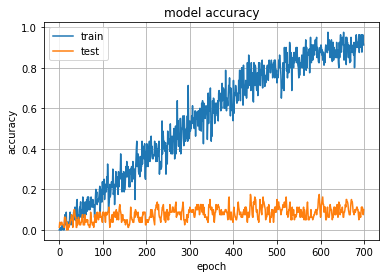

In [16]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

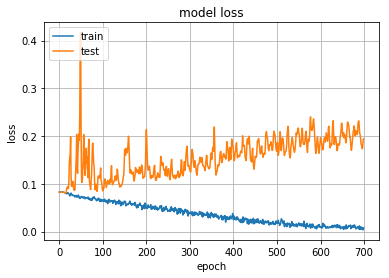

In [17]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [18]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_11_7_msrgb.jpg is: airport_terminal
file airport_25_0_msrgb.jpg is: lighthouse
file airport_11_6_msrgb.jpg is: runway
file airport_3_5_msrgb.jpg is: fountain
file airport_17_4_msrgb.jpg is: stadium


In [19]:
loadedModel = load_model("DenseNet161Model.h5")

path = trainDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
file airport_151_9_msrgb.jpg is: airport
file airport_117_6_msrgb.jpg is: airport
file airport_81_1_msrgb.jpg is: airport
file airport_67_1_msrgb.jpg is: airport
file airport_72_2_msrgb.jpg is: airport
file airport_274_9_msrgb.jpg is: airport
file airport_407_0_msrgb.jpg is: airport
file airport_222_1_msrgb.jpg is: airport
file airport_41_8_msrgb.jpg is: lighthouse
file airport_185_1_msrgb.jpg is: airport
file airport_18_0_msrgb.jpg is: airport
file airport_315_0_msrgb.jpg is: airport
file airport_64_5_msrgb.jpg is: airport
file airport_195_4_msrgb.jpg is: airport
file airport_254_0_msrgb.jpg is: airport
